# Imports

In [2]:
import os
import zipfile
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Estrazione del dataset

In [3]:
DATASET_ZIP_PATH="animals.zip"
DATASET_IMGS_DESTDIR="./"

if not os.path.isdir(DATASET_IMGS_DESTDIR + "animals"):
    if not os.path.isfile(DATASET_ZIP_PATH):
        raise FileNotFoundError(f" !! Unable to continue, could not find zipped dataset to extract dataset from: {DATASET_ZIP_PATH}")

    with zipfile.ZipFile(DATASET_ZIP_PATH, mode="r") as animalz:
        animalz.extractall(DATASET_IMGS_DESTDIR)

# Caricamento del dataset e split

In [4]:
(training_set, testing_set) = keras.utils.image_dataset_from_directory(
    DATASET_IMGS_DESTDIR + "animals",
    subset="both",
    seed=1234,
    validation_split=0.15,
    image_size=(224,224),
    label_mode="categorical",
    batch_size=8)

Found 26128 files belonging to 10 classes.
Using 22209 files for training.
Using 3919 files for validation.


In [5]:
train_size = int(0.85 * len(training_set))
val_size = int(0.15 * len(training_set))
train_dataset = training_set.take(train_size)
validation_dataset = training_set.skip(train_size).take(val_size)

In [6]:
print("Train batches:", len(train_dataset))
print("Validation batches:", len(validation_dataset))

Train batches: 2360
Validation batches: 416


# Costruzione del modello

In [7]:
def build_model(your_base_model, input_shape=(224,224,3)):
    final_layers = 0

    def alay(x):
        nonlocal final_layers
        final_layers += 1
        return x

    seq_model = keras.Sequential([
        keras.Input(shape=input_shape),
        keras.layers.Rescaling(scale=1 / 255),
        your_base_model(include_top=False, input_shape=input_shape),
        alay(keras.layers.GlobalMaxPooling2D()),
        alay(keras.layers.Dropout(0.3)),

        #alay(keras.layers.Dense(
        #    528,
        #    kernel_initializer=keras.initializers.HeUniform(),
        #    bias_initializer=keras.initializers.HeUniform(),
        #    activation=keras.activations.relu)),
        #alay(keras.layers.Dense(
        #    264,
        #    kernel_regularizer=keras.regularizers.L2(),
        #    kernel_initializer=keras.initializers.HeUniform(),
        #    bias_initializer=keras.initializers.HeUniform(),
        #    activation=keras.activations.relu)),
        #alay(keras.layers.Dense(
        #    70,
        #    kernel_regularizer=keras.regularizers.L1(),
        #    kernel_initializer=keras.initializers.GlorotUniform(),
        #    bias_initializer=keras.initializers.GlorotUniform(),
        #    activation=keras.activations.sigmoid)),

        alay(keras.layers.Dense(
            10,
            kernel_initializer=keras.initializers.GlorotUniform(),
            bias_initializer=keras.initializers.GlorotUniform(),
            activation=keras.activations.softmax))
    ])

    freezing_layers = seq_model.layers[:len(seq_model.layers) - final_layers]
    for layer in freezing_layers:
        layer.trainable = False

    return seq_model

In [8]:
model = build_model(keras.applications.NASNetMobile)

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ nasnet_mobile (Functional)           │ (None, 7, 7, 1056)          │       4,269,716 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 1056)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1056)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          10,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,280,286 (16.33 MB)

 Trainable params: 10,570 (41.29 KB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy()
    ])

# Addestramento del modello

In [ ]:
def lr_scheduler(epoch, lr):
  if epoch < 2:
    return lr

  return lr * np.exp(-0.25)

model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.EarlyStopping(
            start_from_epoch=3,
            patience=3,
            restore_best_weights=True),
        keras.callbacks.LearningRateScheduler(
            lr_scheduler
        )])

Epoch 1/50
 332/2360 ━━━━━━━━━━━━━━━━━━━━ 24:22 721ms/step - categorical_accuracy: 0.6101 - loss: 2.7111

# Provare a fare predizioni

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


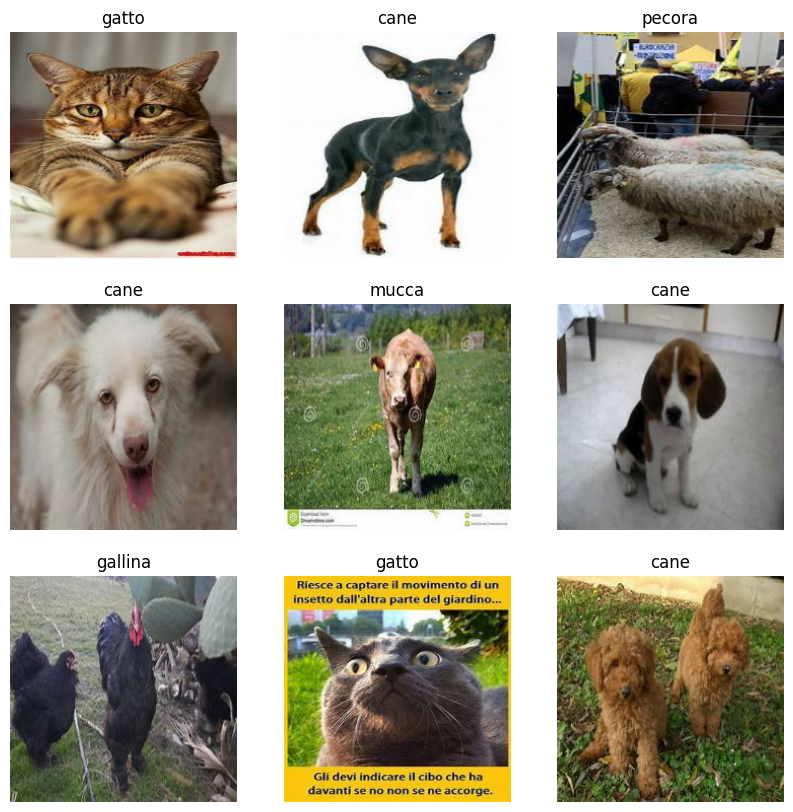

In [ ]:
def predict_3x3_from_dataset(dataset, m):
    d = {
        0 : "cane",
        1 : "cavallo",
        2 : "elefante",
        3 : "farfalla",
        4 : "gallina",
        5 : "gatto",
        6 : "mucca",
        7 : "pecora",
        8 : "ragno",
        9 : "scoiattolo"
    }

    shuffled_dataset = dataset.take(1).shuffle(buffer_size=10)
    plt.figure(figsize=(10, 10))
    for images, labels in shuffled_dataset:
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        resized = tf.image.resize([images[i]], (224,224))
        inputs = tf.reshape(resized, (1, 224, 224, 3))
        y = m.predict(inputs)
        plt.title(d[np.argmax(y)])
        plt.axis("off")

predict_3x3_from_dataset(validation_dataset, model)